# PopSparse Analysis & Figures

Copyright (c) 2023 Graphcore Ltd.


## Preamble

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize

matplotlib.rcdefaults()
sns.set_context("paper", font_scale=1.3)
matplotlib.rc('font', family="serif")
matplotlib.rc('text', usetex=False)  # True

!mkdir -p out
def save(name, fig=None):
    fname = f"out/{name}.pdf"
    if fig:
        fig.savefig(fname, bbox_inches="tight")
    else:
        plt.savefig(fname, bbox_inches="tight")

In [2]:
df = pd.read_json("data/202301_sparsity_benchmarks.json")
df.head()

,m,k,n,density,block_size,type,device,method,valid,flop_count,flop_rate
0,256,1024,1024,1.0,NaN,FP32,GPU,dense,True,536870912,6.954431e+12
1,256,1024,1024,1.0,NaN,FP16,GPU,dense,True,536870912,2.515513e+13
2,256,1024,16,1.0,NaN,FP32,GPU,dense,True,8388608,3.122435e+11
3,256,1024,16,1.0,NaN,FP16,GPU,dense,True,8388608,3.804150e+11
4,256,1024,1,1.0,NaN,FP32,GPU,dense,True,524288,1.413815e+10


In [3]:
# Warning: this takes a while.

def best_flop_rate(d: pd.DataFrame) -> pd.DataFrame:
    best_idx = d.flop_rate.idxmax()
    if np.isnan(best_idx):
        return d.loc[[]]
    return d.loc[best_idx]

def max_over(df: pd.DataFrame, *cols: str) -> pd.DataFrame:
    id_cols = ["m", "k", "n", "density", "block_size", "device", "method", "type"]
    for col in cols:
        id_cols.remove(col)
    return (df.groupby(id_cols, dropna=False)
            .apply(lambda s: best_flop_rate(s)[list(cols) + ["valid", "flop_count", "flop_rate"]])
            .reset_index())

def add_dense_as_sparse(df: pd.DataFrame) -> pd.DataFrame:
    d = df[df.method == "dense"]
    densities = set(df.density.unique()) - {1}
    block_sizes = set(df.block_size.unique())
    return pd.concat([df] + [
        d.assign(
            flop_rate=d.flop_rate * density,
            flop_count=d.flop_count * density,
            density=density,
            block_size=block_size,
        )
        for density in densities
        for block_size in block_sizes
    ]).reset_index()

dfm = max_over(df, "n")
dfb = max_over(df, "n", "block_size")
dfa = max_over(df, "m", "k", "n", "block_size", "method")
dfbb = max_over(df, "block_size")

# Results

## `dense_ipu_gpu`

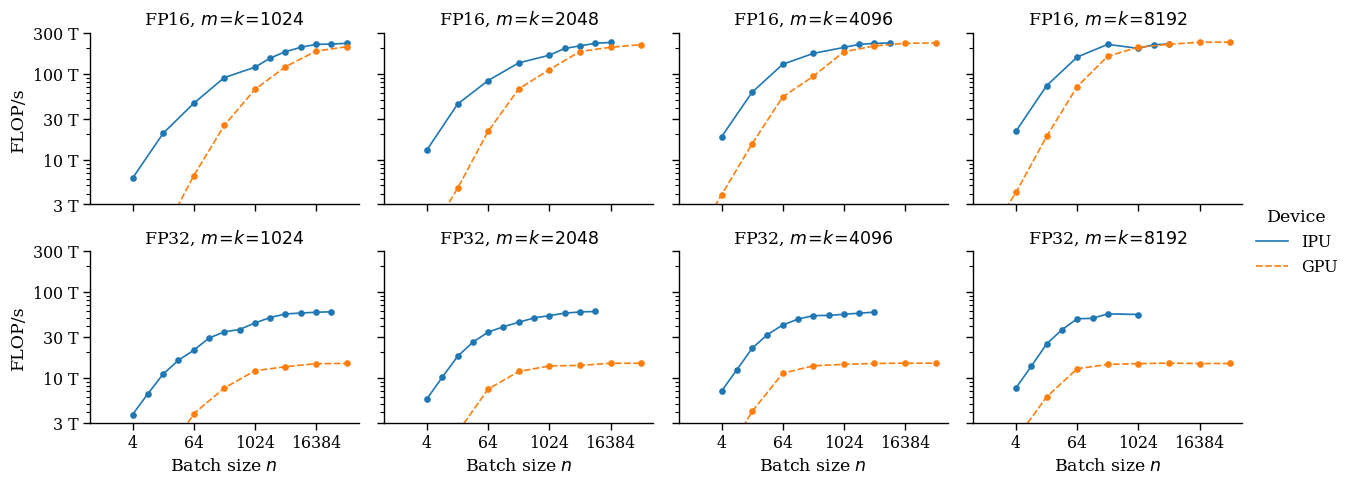

In [16]:
d = (df
    .pipe(lambda d: d[d.method == "dense"])
    .pipe(lambda d: d[d.m == d.k])
    .pipe(lambda d: d[d.k.isin([1024, 2048, 4096, 8192])])
    .sort_values("type")
)
g = sns.relplot(data=d.rename(columns=dict(flop_rate="floprate")), y="floprate", x="n", col="k", row="type",
                hue="device", hue_order=["IPU", "GPU"],
                style="device", style_order=["IPU", "GPU"],
                kind="line", marker="o", markeredgewidth=0,
                aspect=1.25, height=2.5)
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_xlabel("Batch size $n$")
    ax.set_xticks([2**n for n in [2, 6, 10, 14]])
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_yscale("log", base=10)
    ax.set_ylim((3e12, 3e14))
    ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
    ax.set_ylabel("FLOP/s")
    ax.set_yticks([3e12, 1e13, 3e13, 1e14, 3e14])

g.set_titles(r"{row_name}, $m\!=\!k\!=\!{col_name}$")
g.legend.set_title("Device")
save("dense_ipu_gpu");

## `ipu_density`

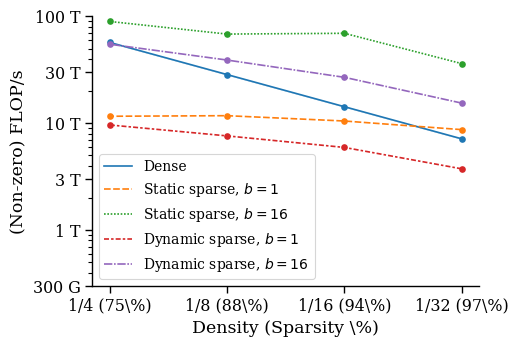

In [5]:
d = (dfm
 .pipe(add_dense_as_sparse)
 .pipe(lambda d: d[d.device == "IPU"])
 .pipe(lambda d: d[d.m == d.k])
 .pipe(lambda d: d[d.m == 4096])
 .pipe(lambda d: d[d.block_size.isin([1, 16])])
 .pipe(lambda d: d[d.density >= 1/32])
 .pipe(lambda d: d[d.type == "FP16"])
 # Labelling
 .pipe(lambda d: d.assign(name=d.apply(
     lambda s: dict(dense="Dense", static_sparse="Static sparse", dynamic_sparse="Dynamic sparse")[s.method] +
     (f", $b={s.block_size:.0f}$" if s.method != "dense" else ""),
     axis=1)))
 .rename(columns=dict(density="Density (Sparsity \%)", flop_rate="(Non-zero) FLOP/s"))
)
plt.figure(figsize=(5, 3.5))
g = sns.lineplot(data=d, y="(Non-zero) FLOP/s", x="Density (Sparsity \%)",
                 hue="name", hue_order=["Dense", "Static sparse, $b=1$", "Static sparse, $b=16$", "Dynamic sparse, $b=1$", "Dynamic sparse, $b=16$"],
                 style="name", style_order=["Dense", "Static sparse, $b=1$", "Static sparse, $b=16$", "Dynamic sparse, $b=1$", "Dynamic sparse, $b=16$"],
                 marker="o", markeredgewidth=0)

g.axes.invert_xaxis()
g.axes.set_xscale("log", base=2)
g.axes.set_xticks([1/4, 1/8, 1/16, 1/32])
g.axes.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda d, _: f"1/{int(1/d)} ({100*(1-d):.0f}\%)"))

g.axes.set_yscale("log", base=10)
g.axes.set_ylim(3e11, 1e14)
g.axes.set_yticks([3e11, 1e12, 3e12, 1e13, 3e13, 1e14])
g.axes.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())

g.legend(loc="lower left", fontsize=10)
sns.despine()
save("ipu_density");

## `gpu_density`

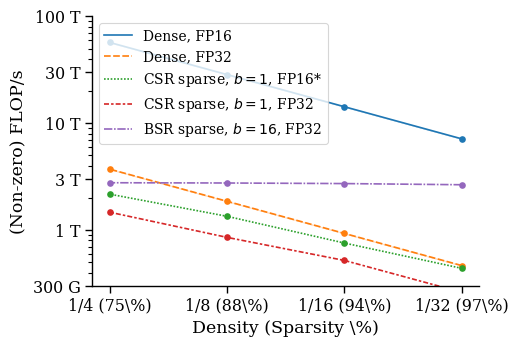

In [6]:
d = (dfm
 .pipe(add_dense_as_sparse)
 .pipe(lambda d: d[d.density < 1])
 .pipe(lambda d: d[d.device == "GPU"])
 .pipe(lambda d: d[d.m == d.k])
 .pipe(lambda d: d[d.m == 4096])
 .pipe(lambda d: d[d.density >= 1/32])
 .pipe(lambda d: d[(d.method != "bsr_sparse") | (d.block_size == 16)])
 .pipe(lambda d: d.assign(name=d.apply(lambda s: f"{s.method} {s.type}", axis=1)))
 # Labelling
 .pipe(lambda d: d.assign(name=d.apply(
     lambda s: dict(dense="Dense", csr_sparse="CSR sparse, $b=1$", bsr_sparse="BSR sparse, $b=16$")[s.method] +
     f", {s.type}",
     axis=1)))
 .rename(columns=dict(density="Density (Sparsity \%)", flop_rate="(Non-zero) FLOP/s"))
)
plt.figure(figsize=(5, 3.5))
g = sns.lineplot(data=d, y="(Non-zero) FLOP/s", x="Density (Sparsity \%)",
                 hue="name", hue_order=["Dense, FP16", "Dense, FP32", "CSR sparse, $b=1$, FP16*", "CSR sparse, $b=1$, FP32", "BSR sparse, $b=16$, FP32"],
                 style="name", style_order=["Dense, FP16", "Dense, FP32", "CSR sparse, $b=1$, FP16*", "CSR sparse, $b=1$, FP32", "BSR sparse, $b=16$, FP32"],
                 marker="o", markeredgewidth=0)

g.axes.invert_xaxis()
g.axes.set_xscale("log", base=2)
g.axes.set_xticks([1/4, 1/8, 1/16, 1/32])
g.axes.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda d, _: f"1/{int(1/d)} ({100*(1-d):.0f}\%)"))

g.axes.set_yscale("log", base=10)
g.axes.set_ylim(3e11, 1e14)
g.axes.set_yticks([3e11, 1e12, 3e12, 1e13, 3e13, 1e14])
g.axes.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())

g.legend(loc="upper left", fontsize=10)
sns.despine()
save("gpu_density");

## `ipu_block_size`

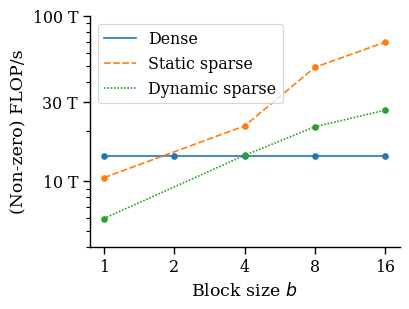

In [7]:
d = (dfm
 .pipe(add_dense_as_sparse)
 .pipe(lambda d: d[d.device == "IPU"])
 .pipe(lambda d: d[d.m == d.k])
 .pipe(lambda d: d[d.m == 4096])
 .pipe(lambda d: d[d.density == 1/16])
 .pipe(lambda d: d[d.type == "FP16"])
 # Labelling
 .pipe(lambda d: d.assign(method=d.method.apply(
     dict(dense="Dense", static_sparse="Static sparse", dynamic_sparse="Dynamic sparse").__getitem__)))
 .rename(columns=dict(density="Density", flop_rate="(Non-zero) FLOP/s", block_size="Block size $b$"))
)
plt.figure(figsize=(4, 3))
g = sns.lineplot(data=d, y="(Non-zero) FLOP/s", x="Block size $b$",
                 hue="method", hue_order=["Dense", "Static sparse", "Dynamic sparse"],
                 style="method", style_order=["Dense", "Static sparse", "Dynamic sparse"],
                 marker="o", markeredgewidth=0)

g.axes.set_xscale("log", base=2)
g.axes.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0f}"))

g.axes.set_yscale("log", base=10)
g.axes.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
g.axes.set_ylim(4e12, 1e14)
g.axes.set_yticks([1e13, 3e13, 1e14])
g.legend(loc="upper left")
# g.legend_.remove()
sns.despine()
save("ipu_block_size");

## `ipu_feature_size`

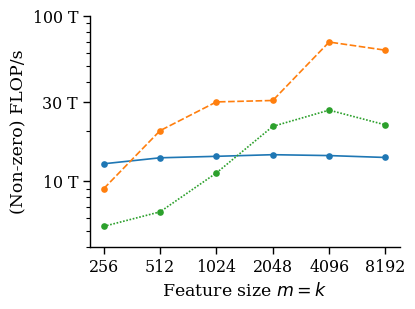

In [8]:
d = (dfm
 .pipe(add_dense_as_sparse)
 .pipe(lambda d: d[d.device == "IPU"])
 .pipe(lambda d: d[d.m == d.k])
 .pipe(lambda d: d[d.density == 1/16])
 .pipe(lambda d: d[d.m.apply(lambda x: round(2**(round(np.log2(x)))) == x)])
 .pipe(lambda d: d[d.type == "FP16"])
 .pipe(lambda d: d[d.block_size == 16])
 # Labelling
 .pipe(lambda d: d.assign(method=d.method.apply(
     dict(dense="Dense", static_sparse="Static sparse", dynamic_sparse="Dynamic sparse").__getitem__)))
 .rename(columns=dict(m="Feature size $m=k$", flop_rate="(Non-zero) FLOP/s", block_size="Block size"))
)
plt.figure(figsize=(4, 3))
g = sns.lineplot(data=d, y="(Non-zero) FLOP/s", x="Feature size $m=k$",
                 hue="method", hue_order=["Dense", "Static sparse", "Dynamic sparse"],
                 style="method", style_order=["Dense", "Static sparse", "Dynamic sparse"],
                 marker="o", markeredgewidth=0)

g.axes.set_xscale("log", base=2)
g.axes.set_xticks([256, 512, 1024, 2048, 4096, 8192])
g.axes.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0f}"))

g.axes.set_yscale("log", base=10)
g.axes.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
g.axes.set_ylim(4e12, 1e14)
g.axes.set_yticks([1e13, 3e13, 1e14])
# g.legend(loc="center left", bbox_to_anchor=(1, 0.5))
g.legend_.remove()
sns.despine()
save("ipu_feature_size");

## `ipu_model`

In [9]:
d = (dfm
 .pipe(add_dense_as_sparse)
 .pipe(lambda d: d[d.device == "IPU"])
 .pipe(lambda d: d[d.method.isin(["dense", "static_sparse"])])
 .pipe(lambda d: d[d.m == d.k])
 .pipe(lambda d: d[d.type == "FP16"])
 .pipe(lambda d: d[d.block_size != 2])
 .pipe(lambda d: d[d.density != 1/64])
#  .pipe(lambda d: d[d.m.isin([512, 1024, 2048, 4096, 8192])])
 .groupby(["m", "density", "block_size"]).apply(lambda g: g[g.method == "static_sparse"][["flop_rate"]] / float(g[g.method=="dense"].flop_rate))
 .reset_index(-1, drop=True)
 .reset_index()
 .rename(columns=dict(flop_rate="speedup"))
)

def model(x, c_base, c_m, c_density, c_block_size):
    return c_base * x.m ** c_m * x.density ** c_density * x.block_size ** c_block_size

coefficients, _ = scipy.optimize.curve_fit(model, d[["m", "density", "block_size"]], d.speedup, np.ones(4))

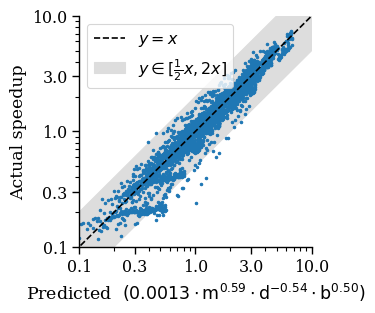

In [10]:
plt.figure(figsize=(3, 3))

xs = np.array([0.01, 100])
tolerance_bar = 2
plt.plot(xs, xs, "k--", label="$y=x$")
plt.fill_between(xs, xs / tolerance_bar, xs * tolerance_bar, color="#ddd", label=r"$y\in[\frac{1}{2}x, 2x]$")
plt.scatter(model(d[["m", "density", "block_size"]], *coefficients), d.speedup, s=3)
plt.legend()

ax = plt.gca()
ax.set_xlabel(
    "Predicted "
    + f" $\\left({coefficients[0]:.4f} \cdot "
    + " \cdot ".join(f"\mathrm{{{n}}}^{{{c:.2f}}}" for n, c in zip(["m", "d", "b"], coefficients[1:]))
    + "\\right)$")
ax.set_ylabel("Actual speedup")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([0.1, 0.3, 1, 3, 10])
ax.set_yticks([0.1, 0.3, 1, 3, 10])
ax.set_xlim((0.1, 10))
ax.set_ylim((0.1, 10))
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
sns.despine()
save("ipu_model");

## `ipu_static_grid`

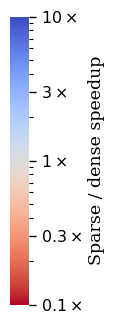

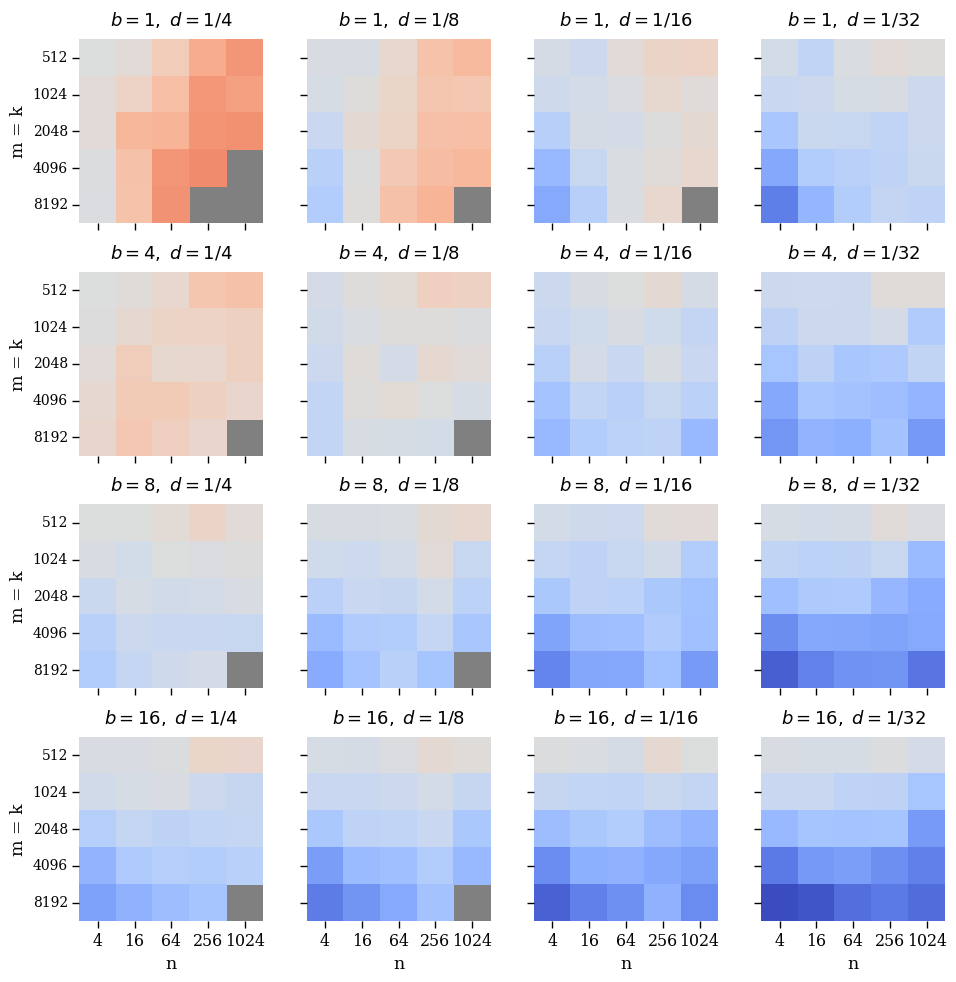

In [11]:
def show_heatmap(method: str) -> None:
    d = (df
        .pipe(add_dense_as_sparse)
        .pipe(lambda d: d[d.type == "FP16"])
        .pipe(lambda d: d[d.device == "IPU"])
        .pipe(lambda d: d[d.method.isin(["dense", method])])
        .pipe(lambda d: d[d.m.isin(2 ** np.arange(9, 14))])
        .pipe(lambda d: d[d.n.isin([4, 16, 64, 256, 1024])])
        .pipe(lambda d: d[d.density.isin([1/32, 1/16, 1/8, 1/4])])
        .pipe(lambda d: d[d.block_size.isin([1, 4, 8, 16])])
        .groupby(["type", "density", "m", "n", "method", "block_size"]).median().reset_index()
        .pipe(lambda d: d.pivot(index=["type", "density", "m", "n", "block_size"], columns="method", values="flop_rate").reset_index())
        # Annotations
        .rename(columns=dict(block_size="Block size"))
    )
    d["improvement"] = d[method] / d.dense
    improvement_range = 10
    g = sns.FacetGrid(data=d, row="Block size", col="density", col_order=sorted(d.density.unique())[::-1], height=2.5)

    f = plt.figure()
    cbar_ax = f.add_axes([.93, .2, .03, .6])

    def show(*_, color, data) -> None:
        grid = data.pivot(index="m", columns="n", values="improvement")
        ax = sns.heatmap(grid, mask=np.isnan(grid),
                         square=True, norm=matplotlib.colors.LogNorm(vmin=1/improvement_range, vmax=improvement_range),
                         cbar_ax=cbar_ax, cmap="coolwarm_r", cbar_kws=dict(label="Sparse / dense speedup"))
        ax.set_facecolor("gray")

    g.map_dataframe(show, "n", "m", "improvement")
    for (block_size, density), ax in g.axes_dict.items():
        ax.set_title(f"$b={int(block_size)},\; d = 1/{int(1/density)}$", pad=10, size=13)
    g.set_ylabels("m = k")
    
    g.set_yticklabels(g.axes[0, 0].get_yticklabels(), fontsize=10)
    
    cb = g.axes[0, 0].collections[-1].colorbar
    cb.set_ticks([0.1, 0.3, 1, 3, 10])
    cb.set_ticklabels([f"${x}\\times$" for x in ["0.1", "0.3", "1", "3", "10"]])
    
    plt.tight_layout()
#     plt.subplots_adjust(hspace=-0.35, wspace=0.1)
    return g, cbar_ax;

g, cbar_ax = show_heatmap("static_sparse")
save("ipu_static_grid")
save("ipu_static_grid_legend", cbar_ax.figure);

# `static_vs_dynamic`

In [12]:
(dfm
 .pipe(add_dense_as_sparse)
 .pipe(lambda d: d[d.m == d.k])
 .pipe(lambda d: d[d.m == 4096])
 .pipe(lambda d: d[d.density == 1/16])
 .pipe(lambda d: d[d.block_size.isin([1, 16])])
 .pipe(lambda d: d.assign(block_size=d.block_size.apply(int)))
 .pipe(lambda d: d[d.device == "IPU"])
 .pipe(lambda d: d[d.method.isin(["dense", "dynamic_sparse", "static_sparse"])])
 .groupby(["block_size", "type"]).apply(lambda g: g.assign(speedup=g.flop_rate/float(g[g.method == "dense"].flop_rate)))
 .reset_index(drop=True)
 .sort_values(["block_size", "type", "speedup"])[["block_size", "type", "method", "n", "speedup"]]
 .pivot(index=["block_size", "type"], columns="method", values="speedup")
 .style.format("{:.1f}")
)